# Assignment 1: Propagation and pass prediction 
This Jupyter Notebook is used in the Satellite Orbits Determination practical (AE4???). This notebook consists of 3 parts:
    - Propagation from a TLE 
    - Pass prediction over Delft ground station
    - Analysis of range-rate data from recording


### UNITS and conventions
All parameters are represented in SI units.

### Code usage
In this course you are using actual tracking data from the DopTrack laboratory and use the Delft-based orbit determination software Tudat to perform orbit analysis.

In [1]:
# Load standard modules
from matplotlib import pyplot as plt

from propagation_functions.environment import *
from propagation_functions.propagation import *
from utility_functions.time import *
from utility_functions.tle import *
from estimation_functions.observations_data import *
from estimation_functions.estimation import *

# Load tudatpy modules
from tudatpy.kernel import constants
from tudatpy.kernel.interface import spice
from tudatpy.kernel.numerical_simulation import propagation_setup
from tudatpy.kernel.astro import element_conversion

In [16]:
# Define import folders
metadata_folder = 'metadata/'
data_folder = 'data/'

# Metadata input file
metadata_file = metadata_folder + 'Delfi-C3_32789_202004020904.yml'

# Retrieve initial state from TLE and associated time
initial_epoch, initial_state_teme = get_tle_initial_conditions(metadata_file)

# Define start of the day (initial time of the propagation)
start_recording_day = get_start_next_day(initial_epoch)

# Define end of the day (final time of the propagation)
nb_days_to_propagate = 2
final_epoch = start_recording_day + nb_days_to_propagate * 86400.0 

print('initial epoch: ', initial_epoch)
print('initial state TEME: ', initial_state_teme)
print('final epoch', final_epoch)

initial epoch:  638983817.0000017
initial state TEME:  [-5.12028710e+06  4.67186002e+06 -1.02444750e+03  6.61803701e+02
  7.22033885e+02  7.51805584e+03]
final epoch 639230400.0


In [4]:
# --------------------------------------
# 1/ Propagate dynamics of Delfi
# --------------------------------------

Warning when processing deprecated propagator settitngs, integrator settings defined independently, and in propagator settings


===============  STARTING SINGLE-ARC PROPAGATION  ===============

PROCESSED STATE VECTOR CONTENTS: 
[Vector entries], content description
[0:5], Translational state of body Delfi w.r.t. Earth

DEPENDENT VARIABLE VECTOR CONTENTS: 
[Vector entries], content description
[0:5], Kepler elements of Delfi w.r.t. Earth
[6], Spherical position angle latitude angle of Delfi w.r.t. Earth
[7], Spherical position angle longitude angle of Delfi w.r.t. Earth




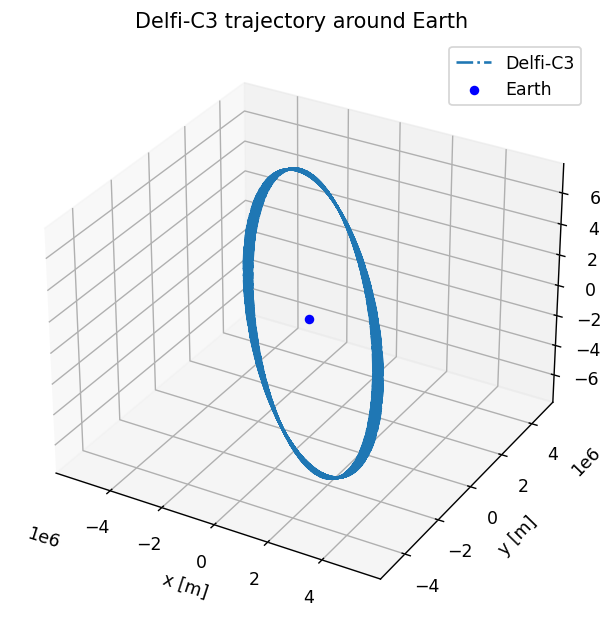

In [27]:
# Define the propagation environment. This function creates a body "Delfi" with the following characteristics.
# The Earth, Sun and Moon are also created, with default settings (gravity field, ephemeris, rotation, etc.)
mass_delfi = 2.2
reference_area_delfi = 0.035
drag_coefficient_delfi = 1.4
srp_coefficient_delfi = 2.4
bodies = define_environment(mass_delfi, reference_area_delfi, drag_coefficient_delfi, srp_coefficient_delfi)

# Set Delfi's initial state to the TLE prediction
initial_state = element_conversion.teme_state_to_j2000(initial_epoch, initial_state_teme)

# # Create numerical integrator settings
# integrator_settings = propagation_setup.integrator.runge_kutta_4(initial_epoch, 10.0)

# Define accelerations exerted on Delfi
# The following can be modified. Warning: point_mass_gravity and spherical_harmonic_gravity accelerations should not be defined simultaneously for a single body
acceleration_models = dict(
    Sun={
        'point_mass_gravity': True,
        'solar_radiation_pressure': True
    },
    Moon={
        'point_mass_gravity': True
    },
    Earth={
        'point_mass_gravity': False,
        'spherical_harmonic_gravity': True,
        'drag': True
    },
    Jupiter={
        'point_mass_gravity': True
    },
    Mars={
        'point_mass_gravity': True
    },
    Venus={
        'point_mass_gravity': True
    }
)
accelerations = create_accelerations(acceleration_models, bodies)

# Create propagator settings
propagator_settings = create_propagator_settings(initial_state, initial_epoch, final_epoch, accelerations)

# Propagate dynamics of the Delfi satellite from initial_epoch to final_epoch, starting from initial_state
# The propagation output is given in cartesian and keplerian states, and the latitude/longitude of the spacecraft are also saved.
cartesian_states, keplerian_states, latitudes, longitudes =\
    propagate_initial_state(initial_state, initial_epoch, final_epoch, bodies, accelerations)

# Plot propagated orbit
fig = plt.figure(figsize=(6,6), dpi=125)
ax = fig.add_subplot(111, projection='3d')
ax.set_title(f'Delfi-C3 trajectory around Earth')
ax.plot(cartesian_states[:, 1], cartesian_states[:, 2], cartesian_states[:, 3], label='Delfi-C3', linestyle='-.')
ax.scatter(0.0, 0.0, 0.0, label="Earth", marker='o', color='blue')
ax.legend()
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
plt.show()

In [ ]:
# Plot Keplerian coordinates and altitude of the propagated orbit


In [ ]:
# plot the ground track and visibility circle of the DopTrack station


In [6]:
# --------------------------------------
# 2/ Detect passes and simulate Doppler
# --------------------------------------

Parameter start index, Parameter definition
0, translational state of (Delfi).

===============  STARTING SINGLE-ARC PROPAGATION  ===============

PROCESSED STATE VECTOR CONTENTS: 
[Vector entries], content description
[0:5], Translational state of body Delfi w.r.t. Earth

DEPENDENT VARIABLE VECTOR CONTENTS: 
[Vector entries], content description
[0:5], Kepler elements of Delfi w.r.t. Earth
[6], Spherical position angle latitude angle of Delfi w.r.t. Earth
[7], Spherical position angle longitude angle of Delfi w.r.t. Earth




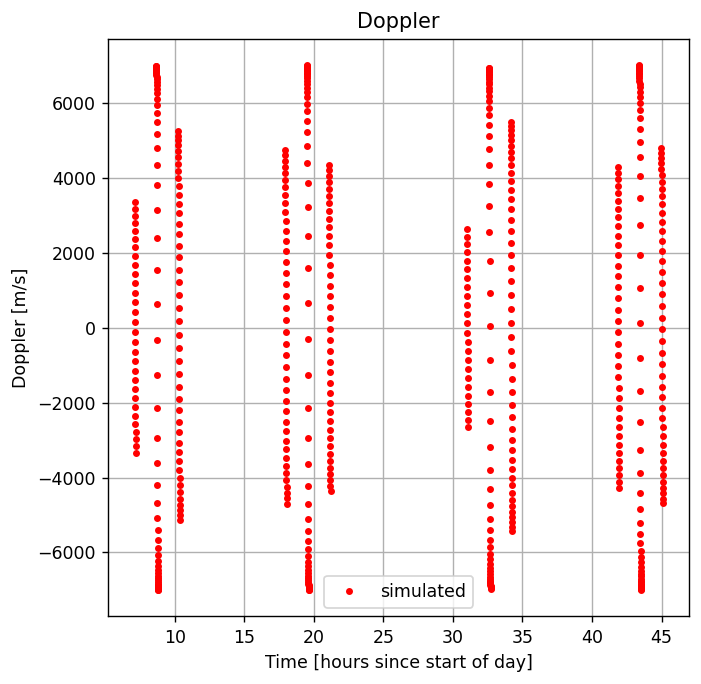

In [28]:
# Create the DopTrack station
define_doptrack_station(bodies)

# Define observation settings
observation_settings = define_ideal_doppler_settings()

# Create list of observation times, with one Doppler measurement every 10 seconds
possible_obs_times = []
obs_time_step = 10.0
current_time = start_recording_day
while current_time < final_epoch:
    possible_obs_times.append(current_time)
    current_time = current_time + obs_time_step

# Simulate (ideal) observations
simulated_observations = simulate_observations(possible_obs_times, observation_settings, propagator_settings, bodies, initial_epoch, 5)

simulated_obs_times = np.array(simulated_observations.concatenated_times)
simulated_doppler = simulated_observations.concatenated_observations


# Plot simulated Doppler data
fig = plt.figure(figsize=(6,6), dpi=125)
ax = fig.add_subplot()
ax.set_title(f'Doppler')
ax.plot((simulated_obs_times - start_recording_day)/3600, simulated_doppler, label='simulated', color='red', linestyle='none', marker='.')
ax.legend()
ax.set_xlabel('Time [hours since start of day]')
ax.set_ylabel('Doppler [m/s]')
plt.grid()
plt.show()

In [ ]:
# plot elevation and azimuth of the passes (max and horizon)


In [8]:
# --------------------------------------
# 3/ Load real observations
# --------------------------------------

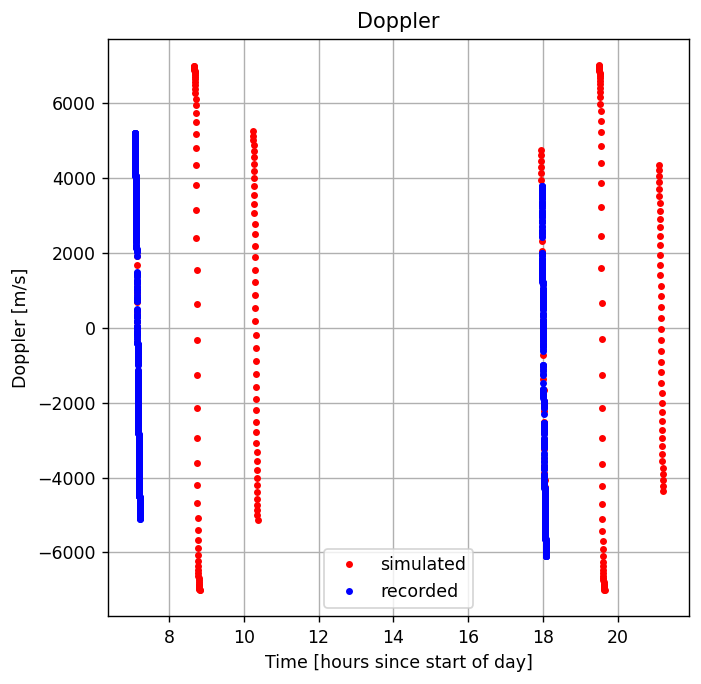

In [9]:
# Observation files to be uploaded
data = ['Delfi-C3_32789_202004020904.DOP1C', 'Delfi-C3_32789_202004021953.DOP1C']

# Process observations.
# This loads the recorded observations and retrieve the start of each tracking pass
passes_start_times, observation_times, observations_set = load_and_format_observations(data_folder, data)

# Retrieve measured Doppler values
real_doppler = observations_set.concatenated_observations


# Plot simulated vs. real Doppler
fig = plt.figure(figsize=(6,6), dpi=125)
ax = fig.add_subplot()
ax.set_title(f'Doppler')
ax.plot((np.array(simulated_obs_times) - start_recording_day)/3600, simulated_doppler, label='simulated', color='red', linestyle='none', marker='.')
ax.plot((np.array(observation_times) - start_recording_day)/3600, convert_frequencies_to_range_rate(real_doppler), label='recorded', color='blue', linestyle='none', marker='.')
ax.legend()
ax.set_xlabel('Time [hours since start of day]')
ax.set_ylabel('Doppler [m/s]')
plt.grid()
plt.show()